In [1]:
import requests
import json
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from scipy.stats import pearsonr, spearmanr
from shapely.geometry import Point
from collections import Counter
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

## Data Processing

In [2]:
# process zip code list of sdge service territory
sdge_zip = pd.read_excel("data/sdge_zip.xlsx", sheet_name=0)
unique_zip = sdge_zip['ZIP_CODE'].unique().tolist()
print(unique_zip)
print("There are " + str(len(unique_zip)) + " unique zip codes")

[91901, 91902, 91905, 91906, 91910, 91911, 91912, 91913, 91914, 91915, 91916, 91917, 91931, 91932, 91934, 91935, 91941, 91942, 91945, 91948, 91950, 91962, 91963, 91970, 91977, 91978, 91980, 92003, 92004, 92007, 92008, 92009, 92010, 92011, 92014, 92019, 92020, 92021, 92023, 92024, 92025, 92026, 92027, 92028, 92029, 92032, 92036, 92037, 92040, 92041, 92050, 92054, 92055, 92056, 92057, 92058, 92059, 92060, 92061, 92062, 92064, 92065, 92066, 92067, 92068, 92069, 92070, 92071, 92072, 92075, 92078, 92079, 92081, 92082, 92083, 92084, 92085, 92086, 92091, 92092, 92093, 92096, 92101, 92102, 92103, 92104, 92105, 92106, 92107, 92108, 92109, 92110, 92111, 92112, 92113, 92114, 92115, 92116, 92117, 92118, 92119, 92120, 92121, 92122, 92123, 92124, 92126, 92127, 92128, 92129, 92130, 92131, 92132, 92133, 92134, 92135, 92136, 92139, 92145, 92147, 92150, 92152, 92154, 92155, 92158, 92161, 92173, 92179, 92182, 92199, 92536, 92624, 92629, 92649, 92651, 92653, 92654, 92656, 92672, 92673, 92674, 92675, 92676

In [3]:
# load full afdc data into a dataframe
with open('data/afdc_full.json', 'r') as f:
    afdc = json.load(f)
fs = afdc.get('fuel_stations', [])
afdc_df = pd.DataFrame(fs)
# start narrow down to electric car charger within SDG&E service territory
sdge = afdc_df[(afdc_df['fuel_type_code'] == 'ELEC')][['id', 'zip', 'latitude', 'longitude']]
sdge['zip'] = pd.to_numeric(sdge['zip'], errors='coerce').astype('Int64')
sdge = sdge[sdge['zip'].isin(unique_zip)]
sdge = sdge.reset_index(drop=True)
print(sdge.head())
print("Number of electric vehicle chargers in SDG&E service territory:", len(sdge))

      id    zip   latitude   longitude
0   6355  92037  32.899470 -117.243000
1  39886  92020  32.795896 -116.976156
2  39889  92029  33.116492 -117.106837
3  39915  91950  32.659001 -117.100836
4  39916  92056  33.181953 -117.298334
Number of electric vehicle chargers in SDG&E service territory: 1701


In [4]:
# overpass API url and query
# A node is a single point in space defined by its latitude and longitude coordinates.
# A way represents linear or area features by connecting nodes together.
# A relation is more complex type that defines relationships between multiple nodes, ways, or other relations.

lat_min = 32.54
lon_min = -118.06
lat_max = 33.73
lon_max = -116.37

url = "https://overpass-api.de/api/interpreter"
query = f"""
[out:json];
(
  node["shop"]({lat_min},{lon_min},{lat_max},{lon_max});
  way["shop"]({lat_min},{lon_min},{lat_max},{lon_max});
  relation["shop"]({lat_min},{lon_min},{lat_max},{lon_max});
  
  node["amenity"="marketplace"]({lat_min},{lon_min},{lat_max},{lon_max});
  way["amenity"="marketplace"]({lat_min},{lon_min},{lat_max},{lon_max});
  relation["amenity"="marketplace"]({lat_min},{lon_min},{lat_max},{lon_max});
  
  node["building"="retail"]({lat_min},{lon_min},{lat_max},{lon_max});
  way["building"="retail"]({lat_min},{lon_min},{lat_max},{lon_max});
  relation["building"="retail"]({lat_min},{lon_min},{lat_max},{lon_max});
);
out center;
"""

In [5]:
# request
response = requests.get(url, params={"data": query})

# check status code, save data to json, create html
if response.status_code == 200:
    data = response.json()
    print(f"{len(data['elements'])} results.")

    # # save to json
    # with open("shop_sd.json", "w") as file:
    #     json.dump(data, file, indent=2)
    #     print("json saved to shop_sd.json")
else:
    # error handling
    print("Error:", response.status_code)
    print(f"Error: {response.status_code}")

11800 results.


In [6]:
# get nodes from dataset
elements = data["elements"]
df_raw = pd.json_normalize(
    elements,
    sep="_",
    record_path=None,
)

# select wanted cols for nodes
df_nodes = df_raw[df_raw['type']=='node'][["id", "type", "lat", "lon", "tags_name", "tags_shop", "tags_addr:postcode"]]
# rename cols
df_nodes.columns = ["id", "geo_type", "latitude", "longitude", "name", "shop_type", "postal_code"]
print(len(df_nodes))


6229


In [7]:
# select wanted cols for ways
df_ways = df_raw[df_raw['type']=='way'][["id", "type", "center_lat", "center_lon", "tags_name", "tags_shop", "tags_addr:postcode", "nodes"]]
# rename cols
df_ways.columns = ["id", "geo_type", "latitude", "longitude", "name", "shop_type", "postal_code", "nodes"]
print(len(df_ways))

5551


In [8]:
# ignore at this point

# # select wanted cols for relations
# df_relations = df[df['type']=='relation'][["id", "type", "center_lat", "center_lon", "tags_name", "tags_shop", "tags_addr:postcode", "members"]]
# # rename cols
# df_relations.columns = ["id", "geo_type", "latitude", "longitude", "name", "shop_type", "postal_code", "ways"]
# # filter out relations with only one way
# df_relations = df_relations[df_relations['ways'].apply(len) > 1]
# # keep 
# df_relations['ways'] = df_relations['ways'].apply(lambda ways: [way['ref'] for way in ways])
# # save to csv
# df_relations.to_csv("shop_relations_sd.csv", index=False)
# print(len(df_relations))
# print("relations saved to shop_relations_sd.csv")

In [9]:
# concat nodes and ways dfs
df = pd.concat([df_nodes, df_ways], ignore_index=True)

# Truncate postal codes to 5 digits
df['postal_code'] = df['postal_code'].str.extract(r'(\d{5})')

# filter df so that it only has zip codes in unique_zip
unique_zip = [str(z) for z in unique_zip]
df['postal_code'] = df['postal_code'].astype(str)
df = df[df['postal_code'].isin(unique_zip)]

In [10]:
# Get missing zip codes for rows in df

shapefile = "data/tl_2024_us_zcta520.shp"
gdf = gpd.read_file(shapefile)

if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4269")

gdf = gdf.to_crs(epsg=4326)

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Perform spatial join to find matching ZCTAs
result = gpd.sjoin(geo_df, gdf, how='left', predicate='within')

# Update postal_code column with ZCTA values for missing rows
df['postal_code'] = result['ZCTA5CE20'].combine_first(df['postal_code'])


In [11]:
# # save to csv
# df.to_csv("shop_sd.csv", index=False)
# print("combined df saved to shop_sd.csv")
print(df.head())
print(len(df))

          id geo_type   latitude   longitude                    name  \
0  273593057     node  32.866410 -117.232087                  Ralphs   
1  273593515     node  32.865636 -117.232406            Trader Joe's   
2  274188768     node  32.864687 -117.231892                PetSmart   
3  274191517     node  32.851630 -117.214477  Sprouts Farmers Market   
4  274193121     node  32.824288 -117.183720  Sprouts Farmers Market   

     shop_type postal_code nodes  
0  supermarket       92037   NaN  
1  supermarket       92037   NaN  
2          pet       92037   NaN  
3  supermarket       92122   NaN  
4  supermarket       92117   NaN  
3710


In [12]:
# create Folium map
sd_map = folium.Map(location=[32.7157, -117.1611], zoom_start=12)
# add elements
for _, row in df.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    name = row['name']
    shop_type = row['shop_type']
    # add marker
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,  # Size of the dot
        color="blue",  # Outline color
        fill=True,  # Fill the circle
        fill_color="blue",  # Fill color
        fill_opacity=0.7,  # Opacity of the fill
        popup=f"{name} ({shop_type})"  # Popup text
    ).add_to(sd_map)

for _, row in sdge.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color="orange",
        fill=True,
        fill_color="orange",
        fill_opacity=0.7,
        popup=f"Charger ID: {row['id']}; location: {row['latitude'], row['longitude']}"
    ).add_to(sd_map)
# save to html
sd_map.save("data/shop_and_evcharger.html")
print("map saved to shop_and_evcharger.html")

map saved to shop_and_evcharger.html


## Data EDA

In [13]:
# basic information
print("Basic Info:")
print(df.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3710 entries, 0 to 11773
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           3710 non-null   int64  
 1   geo_type     3710 non-null   object 
 2   latitude     3710 non-null   float64
 3   longitude    3710 non-null   float64
 4   name         3124 non-null   object 
 5   shop_type    3160 non-null   object 
 6   postal_code  3710 non-null   object 
 7   nodes        1836 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 260.9+ KB
None


In [14]:
# check missing values
print("Missing Values Count:")
print(df.isnull().sum())

Missing Values Count:
id                0
geo_type          0
latitude          0
longitude         0
name            586
shop_type       550
postal_code       0
nodes          1874
dtype: int64


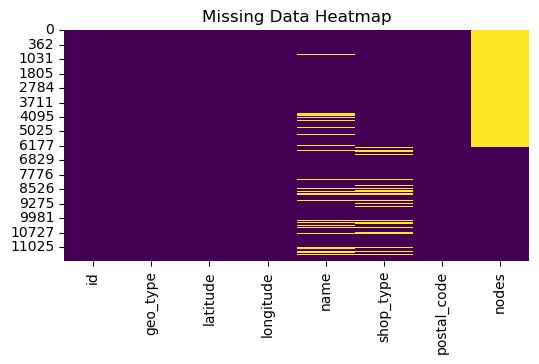

In [15]:
# plot missing data
plt.figure(figsize=(6,3))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

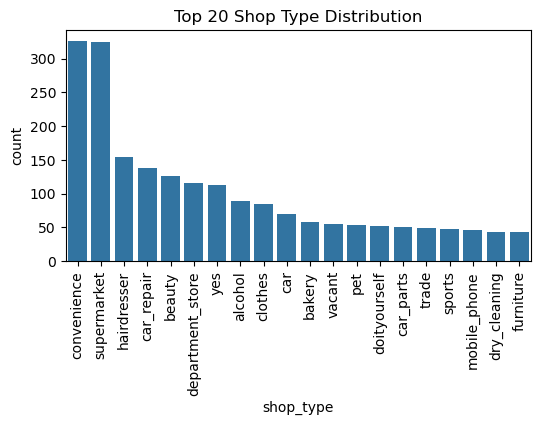

In [16]:
# distribution of some of the shop types
plt.figure(figsize=(6,3))
sns.countplot(data=df, x='shop_type', order=df['shop_type'].value_counts().index[:20])
plt.title('Top 20 Shop Type Distribution')
plt.xticks(rotation=90)
plt.show()

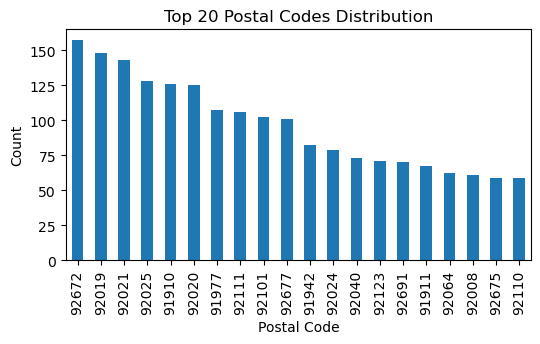

In [17]:
# Distribution of Postal Codes (if available)
plt.figure(figsize=(6,3))
df['postal_code'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Postal Codes Distribution')
plt.xlabel('Postal Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## Correlation Analysis

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance to nearest charging station
df['nearest_charger_distance'] = df.apply(
    lambda row: min(haversine(row['latitude'], row['longitude'], cs['latitude'], cs['longitude']) for _, cs in sdge.iterrows()),
    axis=1
)

# Calculate density of charging stations within 1 km
df['charger_density'] = df.apply(
    lambda row: sum(haversine(row['latitude'], row['longitude'], cs['latitude'], cs['longitude']) <= 1 for _, cs in sdge.iterrows()),
    axis=1
)

# One-hot encode shop_type
df = pd.get_dummies(df, columns=['shop_type'], prefix='shop')

# Drop non-numeric columns before correlation analysis
df_numeric = df.drop(columns=['id', 'nodes', 'name', 'geo_type'], errors='ignore')

# Correlation analysis
correlation_matrix = df_numeric.corr()
print(correlation_matrix['nearest_charger_distance'])

## clustering

In [ ]:
coords = df[['latitude', 'longitude']]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=250, random_state=42)
df['cluster'] = kmeans.fit_predict(coords)

# Calculate convex hull area for each cluster
def calculate_convex_hull_area(cluster_points):
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        polygon = Polygon(cluster_points[hull.vertices])
        return polygon.area
    else:
        return 0

# Create a dictionary to store cluster info
cluster_info = {}

for cluster in df['cluster'].unique():
    cluster_points = df[df['cluster'] == cluster][['latitude', 'longitude']].values
    area = calculate_convex_hull_area(cluster_points)
    shop_count = len(cluster_points)
    cluster_info[cluster] = {'area': area, 'shop_count': shop_count}

# Convert cluster_info to a DataFrame for easier sorting
cluster_df = pd.DataFrame.from_dict(cluster_info, orient='index')

# Rank clusters: first by shop count (descending), then by area (ascending)
cluster_df['rank'] = cluster_df.apply(lambda x: (-x['shop_count'], x['area']), axis=1)
cluster_df = cluster_df.sort_values(by='rank').reset_index()

# Select the top 100 clusters
top_100_clusters = cluster_df.head(100)['index'].tolist()

# Label shops in the top 100 clusters
df['in_top_100'] = df['cluster'].apply(lambda x: x in top_100_clusters)

# Create a base map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Add markers to the map
for idx, row in df.iterrows():
    if row['in_top_100']:
        color = 'black'
    else:
        color = 'blue'
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# Add boundary lines for the top 100 clusters
for cluster in top_100_clusters:
    cluster_points = df[df['cluster'] == cluster][['latitude', 'longitude']].values
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        boundary = cluster_points[hull.vertices]
        folium.PolyLine(
            locations=boundary,
            color='red',
            weight=2,
            opacity=0.7
        ).add_to(m)

# Display the map
m

## parking lot data

In [25]:
lat_min = 32.54
lon_min = -118.06
lat_max = 33.73
lon_max = -116.37

url = "https://overpass-api.de/api/interpreter"
query = f"""
[out:json];
(
  node["amenity"="parking"]({lat_min},{lon_min},{lat_max},{lon_max});
);
out center;
"""

response = requests.post(url, data=query)
if response.status_code == 200:
    pl = response.json()
    print("Data retrieved successfully!")
    with open("data/parking_lot.json", "w") as file:
        json.dump(pl, file, indent=2)
        print("json saved to parking_lot.json")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Data retrieved successfully!
json saved to parking_lot.json


In [26]:
ele = pl["elements"]
pl_df = pd.json_normalize(
    ele,
    sep="_",
    record_path=None,
)

# select wanted cols for nodes
pl_df = pl_df[["id","lat", "lon", "tags_access"]]
# rename cols
pl_df.columns = ["parking_lot_id", "latitude", "longitude", "access"]
print(len(pl_df))

397


In [ ]:
geometry_pl = [Point(xy) for xy in zip(pl_df['longitude'], pl_df['latitude'])]
geo_pl = gpd.GeoDataFrame(pl_df, geometry=geometry_pl, crs="EPSG:4326")

# Perform spatial join to find matching ZCTAs
result_pl = gpd.sjoin(geo_pl, gdf, how='left', predicate='within')

# Update postal_code column with ZCTA values for missing rows
pl_df['zip_code'] = result_pl['ZCTA5CE20']

pl_df.to_csv("parking_lot.csv", index=False)
print("combined df saved to shop_sd.csv")